In [ ]:
#pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models

# general
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

## Загрузка данных 

In [13]:
batch_size = 4

In [14]:
data_transforms = \
{
    'train': 
    [
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ],
    'test': 
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
}

In [15]:
image_datasets = {x: ImageFolder(os.path.join('img', x), transforms.Compose(data_transforms[x])) for x in ['train', 'test']}

In [16]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

In [17]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 6710, 'test': 3305}

In [18]:
class_names = image_datasets['train'].classes
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Визуализация 

In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    
    #revert normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

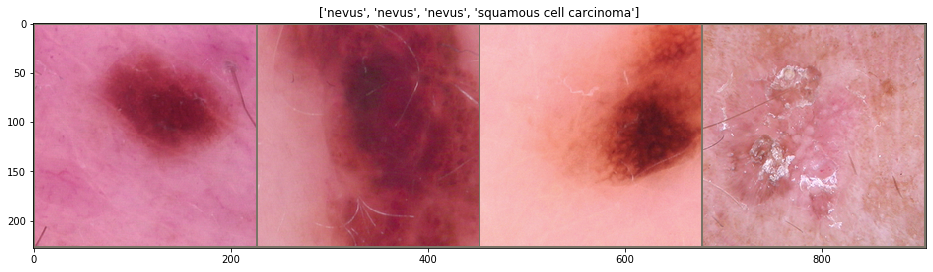

In [21]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Обобщенная функция обучения


In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            is_train_phase = (phase == "train")
            model.train(is_train_phase)
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(is_train_phase):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if is_train_phase:
                        loss.backward()
                        optimizer.step()

                # statistics inputs.size(0) = batch_size 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if is_train_phase:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss : .4f} Acc: {epoch_acc : .4f}")
            # deep copy the model
            if (not is_train_phase) and (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s")
    print(f"Best val Acc: {best_acc : .4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Обучение 

In [30]:
model_dict = {
    "resnet50" : models.resnet50(pretrained=True),
    "inception_v3" : models.inception_v3(pretrained=True),
    "resnet18" : mode
#     "vgg19": models.vgg19(pretrained=True),
#     "alexnet" : models.alexnet(pretrained=True)
}

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
for model_name in model_dict:
    print(model_dict[model_name].fc.in_features)

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [31]:
for model_name in model_dict:
    print(model_dict[model_name].fc.in_features)

2048
2048


AttributeError: 'AlexNet' object has no attribute 'fc'

In [118]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss:  0.9828 Acc:  0.6736
test Loss:  0.8609 Acc:  0.7189

Epoch 2/25
----------
train Loss:  0.8216 Acc:  0.7156
test Loss:  0.8035 Acc:  0.7349

Epoch 3/25
----------
train Loss:  0.7524 Acc:  0.7413
test Loss:  0.8288 Acc:  0.7513

Epoch 4/25
----------
train Loss:  0.6570 Acc:  0.7754
test Loss:  1.1381 Acc:  0.7377

Epoch 5/25
----------
train Loss:  0.6050 Acc:  0.7952
test Loss:  0.8621 Acc:  0.7464

Epoch 6/25
----------
train Loss:  0.5682 Acc:  0.8039
test Loss:  0.8269 Acc:  0.7316

Epoch 7/25
----------
train Loss:  0.5192 Acc:  0.8221
test Loss:  0.8460 Acc:  0.7613

Epoch 8/25
----------
train Loss:  0.3310 Acc:  0.8844
test Loss:  0.7315 Acc:  0.7761

Epoch 9/25
----------
train Loss:  0.2860 Acc:  0.9033
test Loss:  0.7941 Acc:  0.7855

Epoch 10/25
----------
train Loss:  0.2683 Acc:  0.9110
test Loss:  0.7741 Acc:  0.7755

Epoch 11/25
----------
train Loss:  0.2502 Acc:  0.9203
test Loss:  0.7593 Acc:  0.7882

Epoch 12/25
----------
train L

In [ ]:
coeff_path = f"nn_coeffs/pre_learned_no_changes_in_data/resnet18.pth"
torch.save(model_ft.state_dict(), coeff_path)

In [ ]:
next(model_ft.parameters()).is_cuda

In [ ]:
result_dict = {
    "real" : [],
    "predicted" : []
}

with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            result_dict["real"].append(class_names[labels[i]])
            result_dict["predicted"].append(class_names[predicted[i]])

result_df = pd.DataFrame(result_dict)
result_df["answer"] = result_df.apply(lambda x: int(x["real"] == x["predicted"]), axis=1)
result_df.head()

total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
print(f"Total accuracy: {round(total_acc, 2)}%")
print("---------------------")

for img_class in result_df["real"].unique():
    class_df = result_df[result_df["real"] == img_class]
    class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
    print(f"{img_class} ({len(class_df)}) : {round(class_acc, 2)}%")

In [125]:
next(model_ft.parameters()).is_cuda

True

In [133]:
result_dict = {
    "real" : [],
    "predicted" : []
}

with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            result_dict["real"].append(class_names[labels[i]])
            result_dict["predicted"].append(class_names[predicted[i]])

result_df = pd.DataFrame(result_dict)
result_df["answer"] = result_df.apply(lambda x: int(x["real"] == x["predicted"]), axis=1)
result_df.head()

total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
print(f"Total accuracy: {round(total_acc, 2)}%")
print("---------------------")

for img_class in result_df["real"].unique():
    class_df = result_df[result_df["real"] == img_class]
    class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
    print(f"{img_class} ({len(class_df)}) : {round(class_acc, 2)}%")

Total accuracy: 80.03%
---------------------
nevus (2226) : 95.46%
pigmented benign keratosis (343) : 57.43%
melanoma (396) : 26.52%
basal cell carcinoma (165) : 71.52%
actinic keratosis (37) : 75.68%
dermatofibroma (33) : 51.52%
vascular lesion (45) : 93.33%
squamous cell carcinoma (60) : 21.67%
